In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catch22 import catch22_all
import scipy.ndimage as ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import palettable
from pathlib import Path

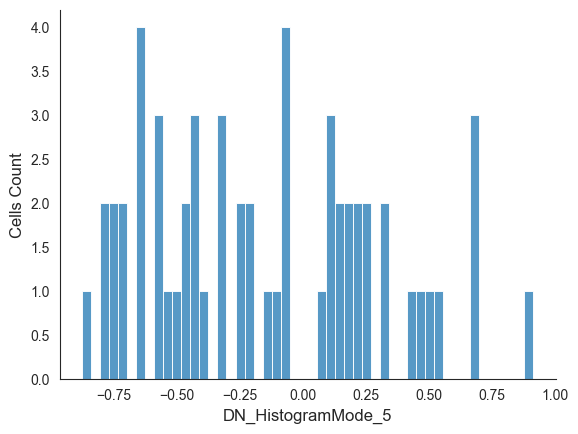

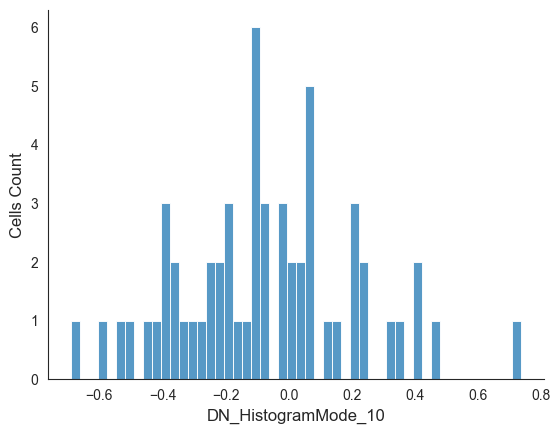

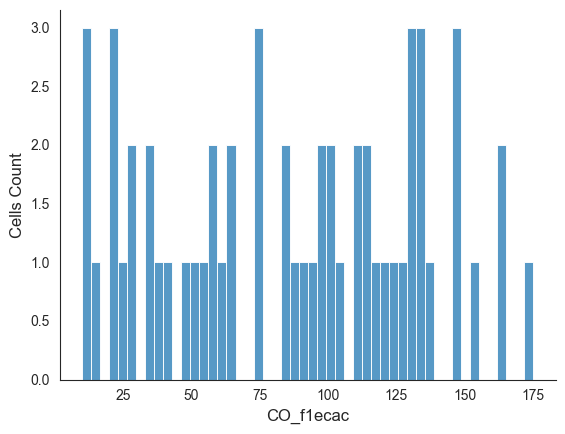

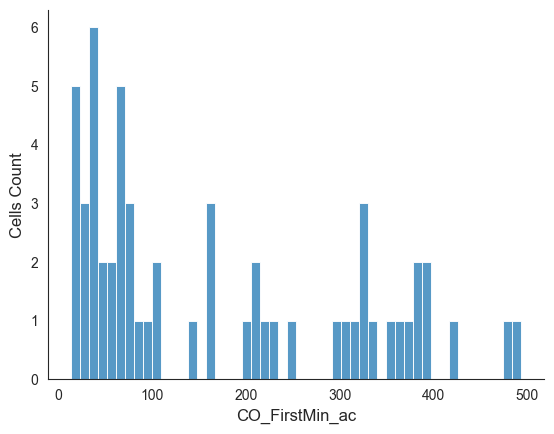

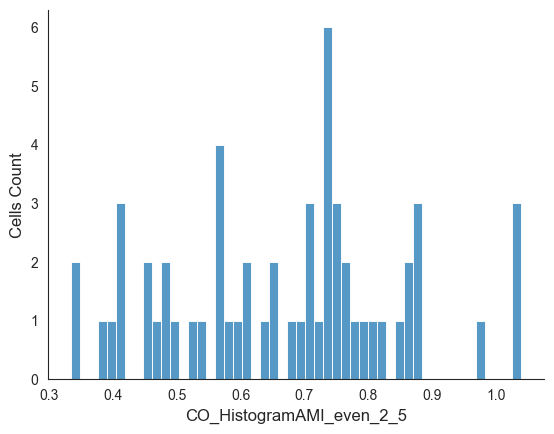

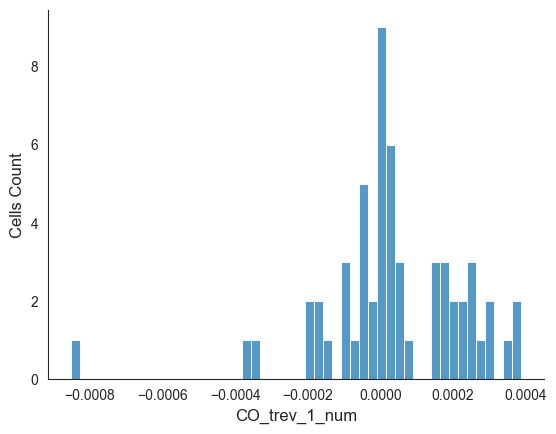

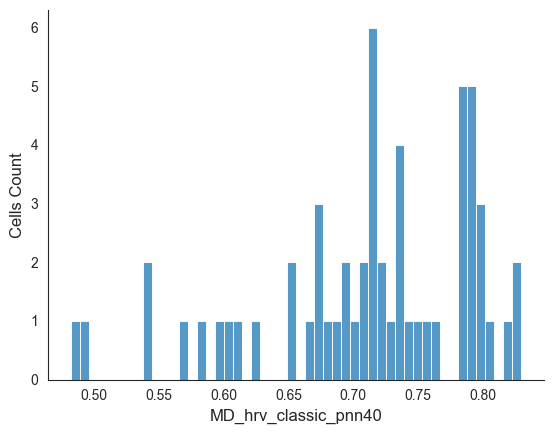

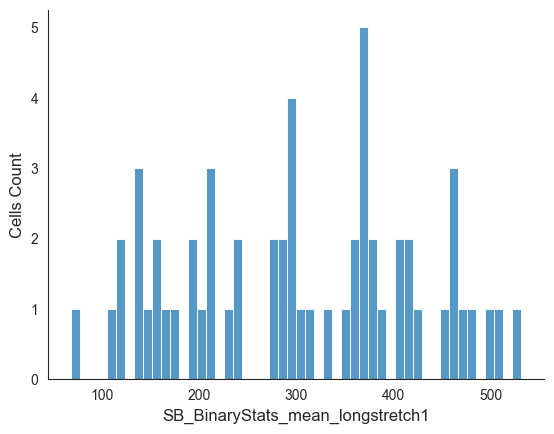

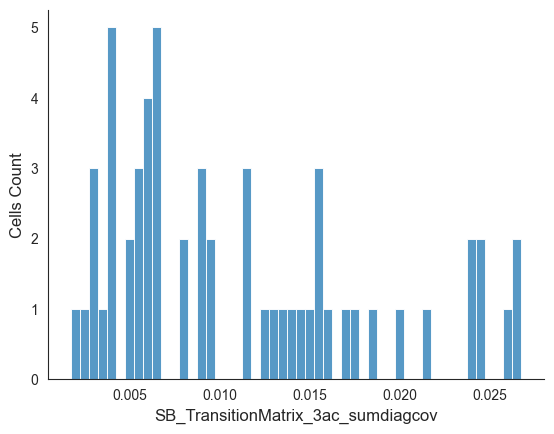

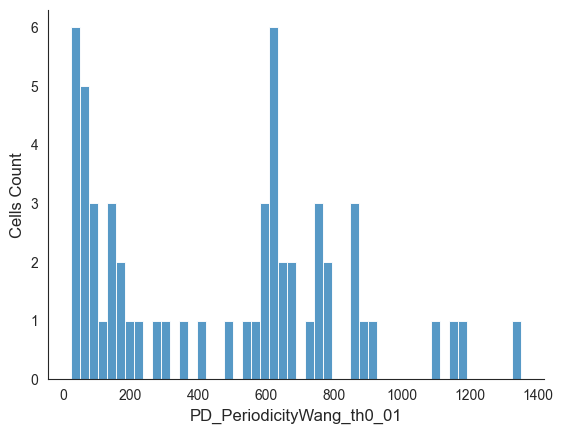

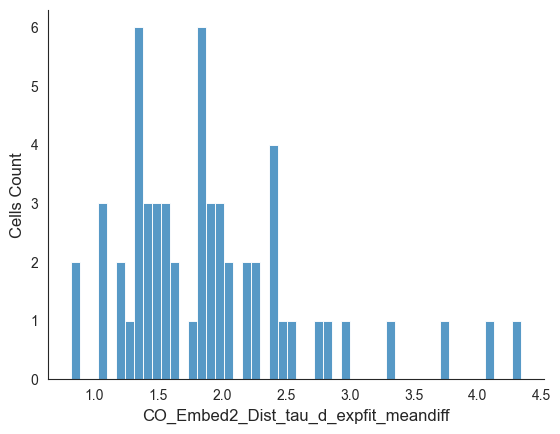

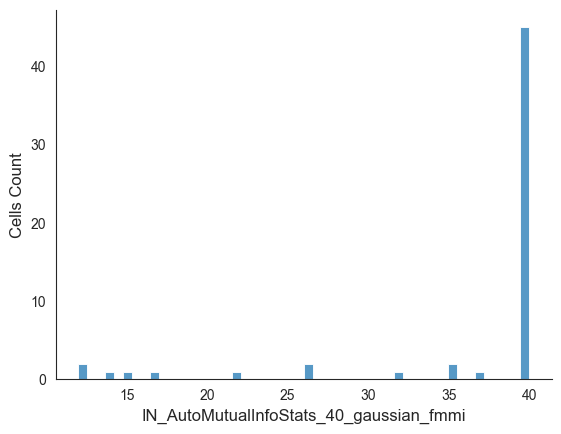

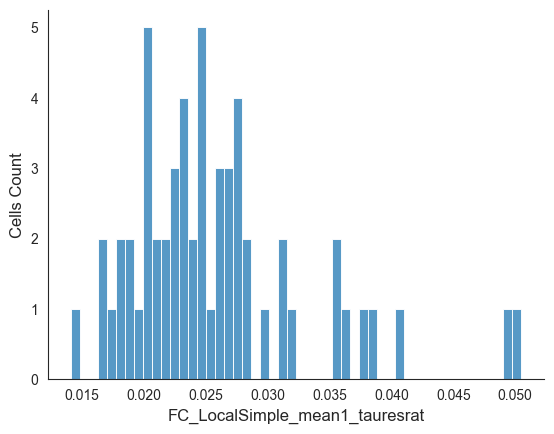

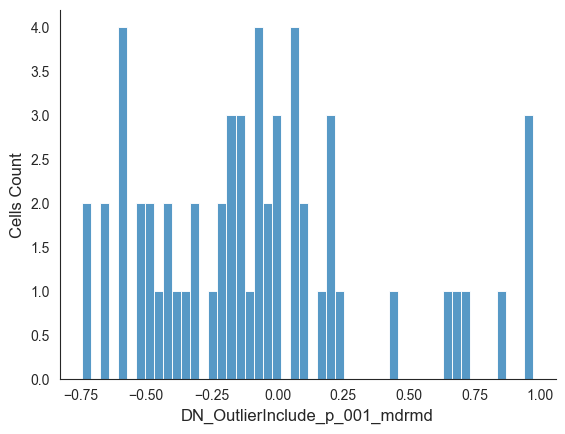

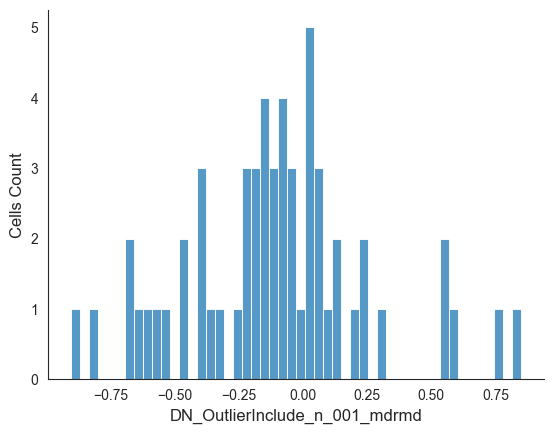

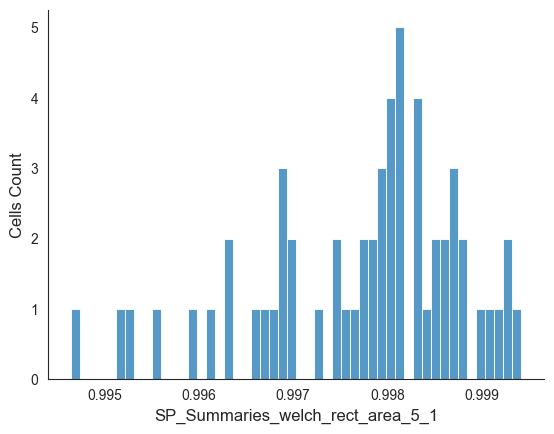

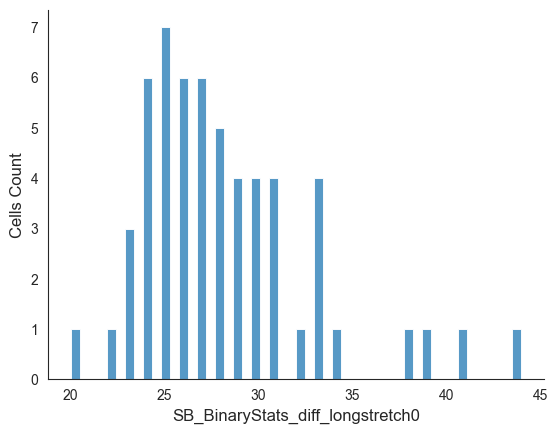

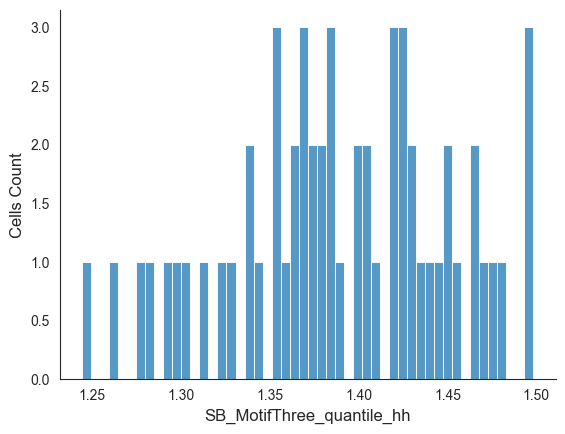

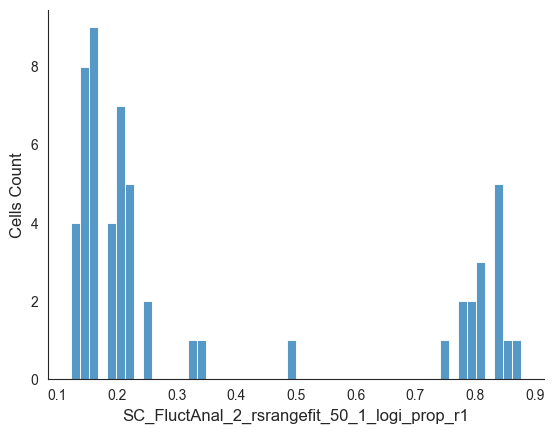

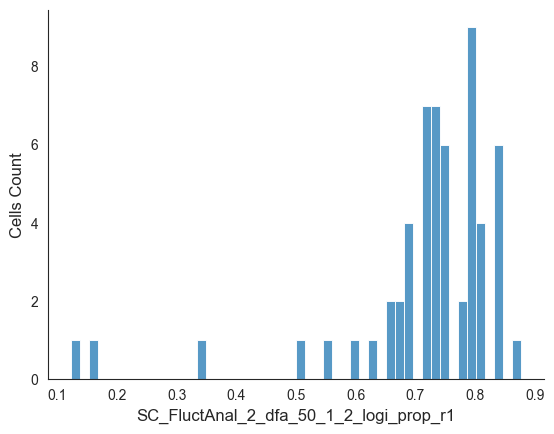

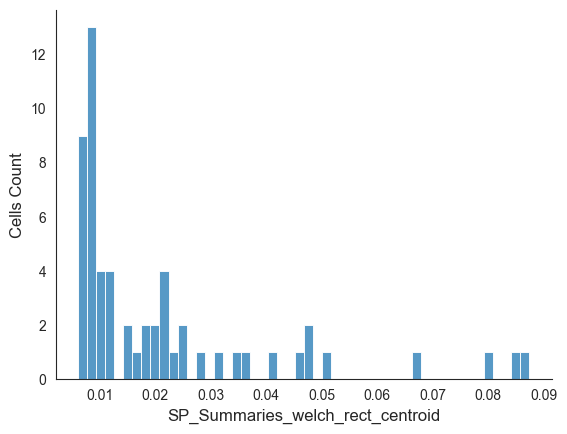

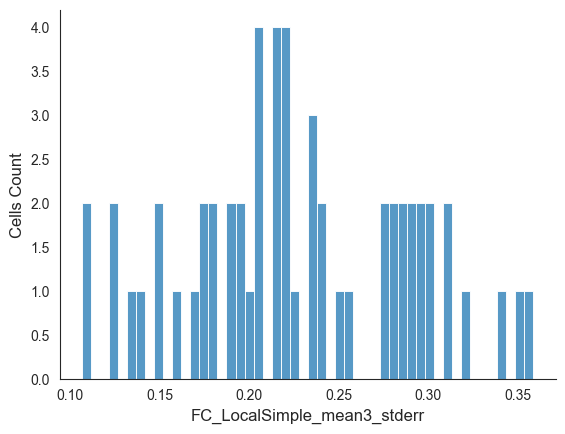

In [4]:
home = Path('R:/home')
top_dir = Path(home, 'firefly_link/cancer')
data_dir = Path(top_dir, "analysis", "full")
initial_df = pd.read_csv(Path(top_dir, 'analysis', 'correct_dataframes', '20220423_original_and_review.csv'))
lines = initial_df.expt

lines2 = [x[1:] if x[0] == "L" else x for x in lines]
initial_df.expt = lines2

line = 'SUM159'
tc_save = Path(top_dir, "analysis", "full", 'tc')
tcs = pd.read_csv(Path(tc_save,f'{line}_none_active_tcs_filt.csv'),index_col = [0])
tcs
features=[]
for i in range(tcs.shape[0]):
    df=tcs.iloc[i,2:]
    #Feature Extraction
    catch22_out=catch22_all(df)['values']
    features.append(catch22_out)
#values=features['values'].apply(pd.Series)
features = pd.DataFrame(features)
features.columns=['DN_HistogramMode_5','DN_HistogramMode_10','CO_f1ecac','CO_FirstMin_ac','CO_HistogramAMI_even_2_5','CO_trev_1_num','MD_hrv_classic_pnn40','SB_BinaryStats_mean_longstretch1','SB_TransitionMatrix_3ac_sumdiagcov','PD_PeriodicityWang_th0_01','CO_Embed2_Dist_tau_d_expfit_meandiff','IN_AutoMutualInfoStats_40_gaussian_fmmi','FC_LocalSimple_mean1_tauresrat','DN_OutlierInclude_p_001_mdrmd','DN_OutlierInclude_n_001_mdrmd','SP_Summaries_welch_rect_area_5_1','SB_BinaryStats_diff_longstretch0','SB_MotifThree_quantile_hh','SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1','SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1','SP_Summaries_welch_rect_centroid','FC_LocalSimple_mean3_stderr']
features

#Raw data distribution
values = features
for i in range(values.shape[1]):
    #plt.figure(dpi=300)
    sns.histplot(values.iloc[:,i],bins=50)
    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.set_style('white')
    #plt.title(values.columns[i])
    plt.xlabel(values.columns[i],fontsize=12)
    plt.ylabel('Cells Count',fontsize=12)
    plt.show()

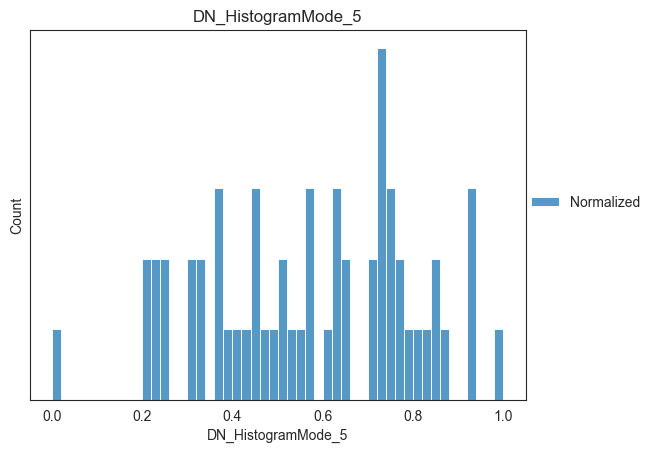

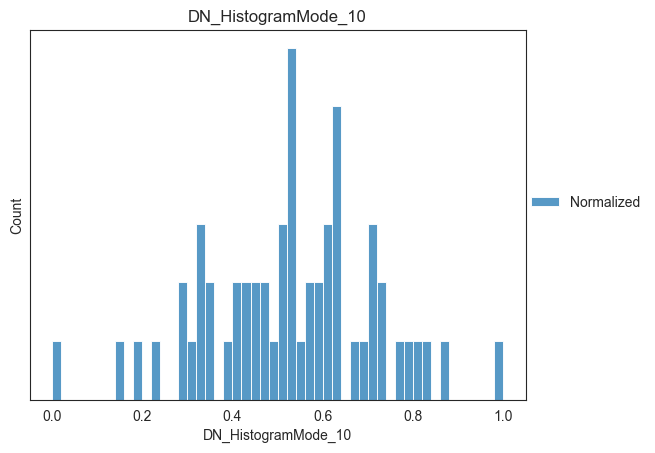

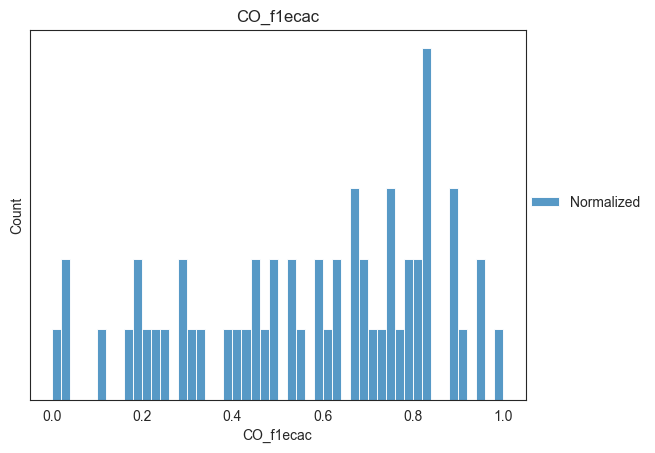

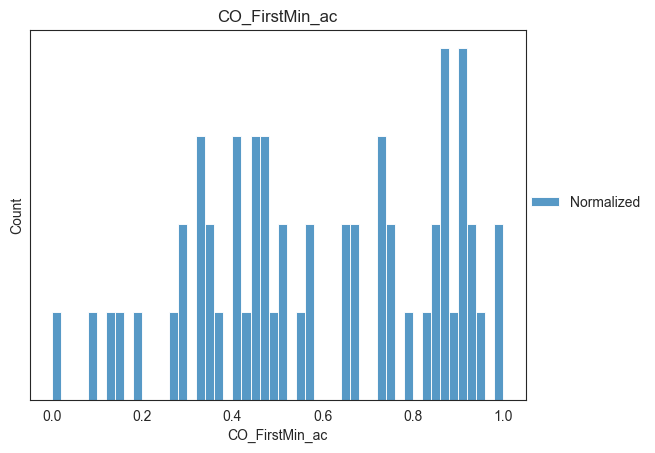

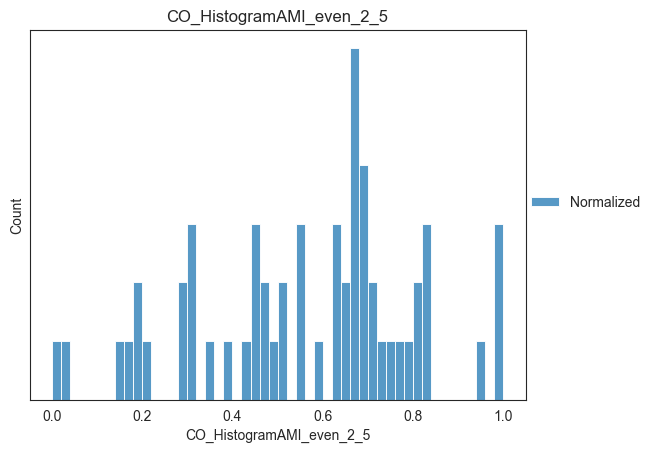

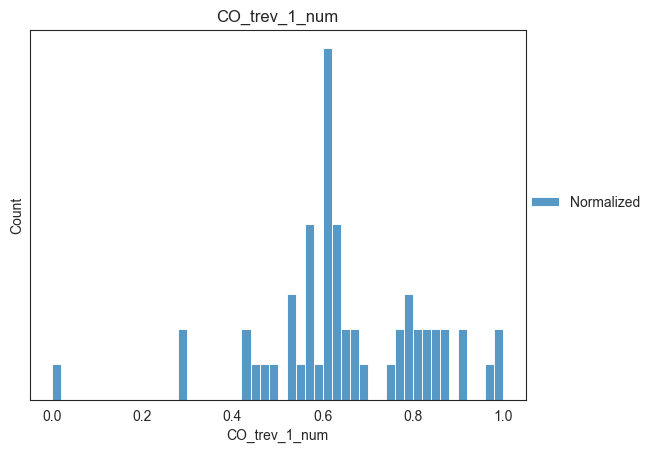

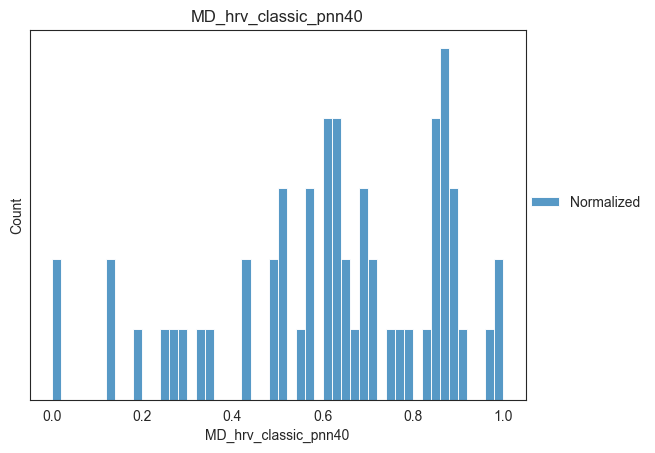

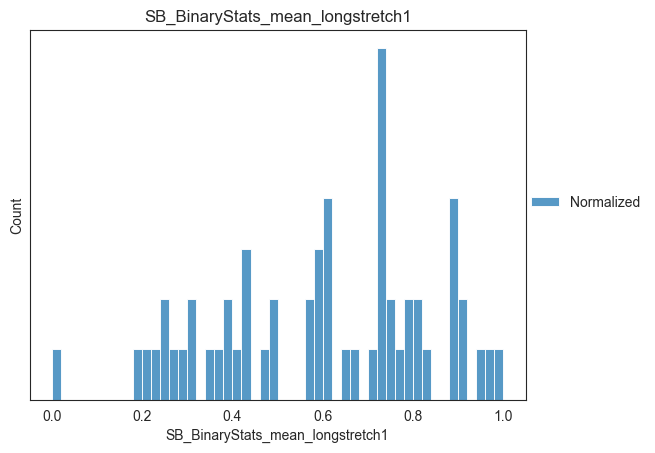

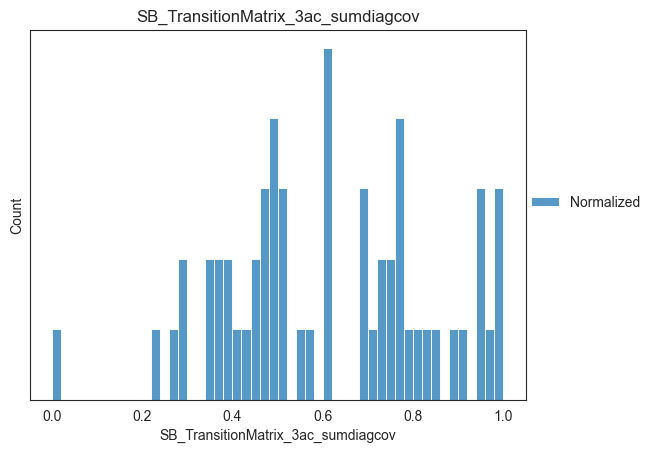

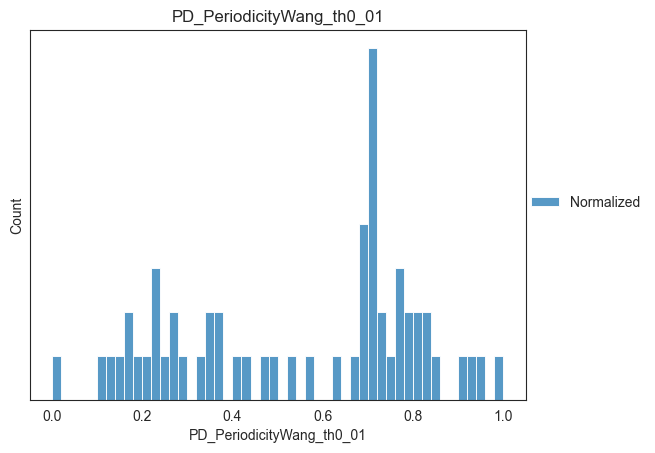

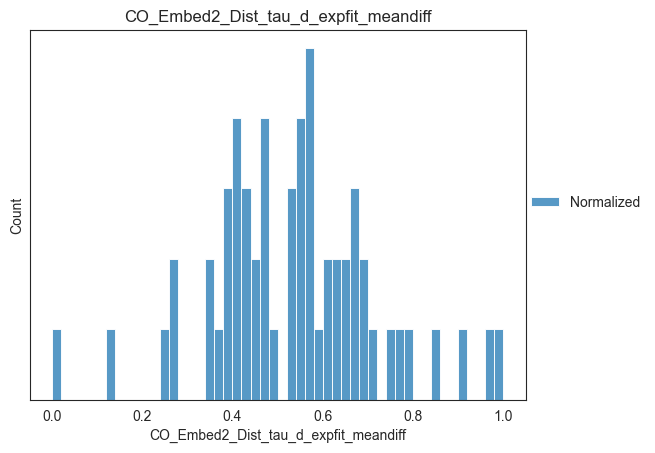

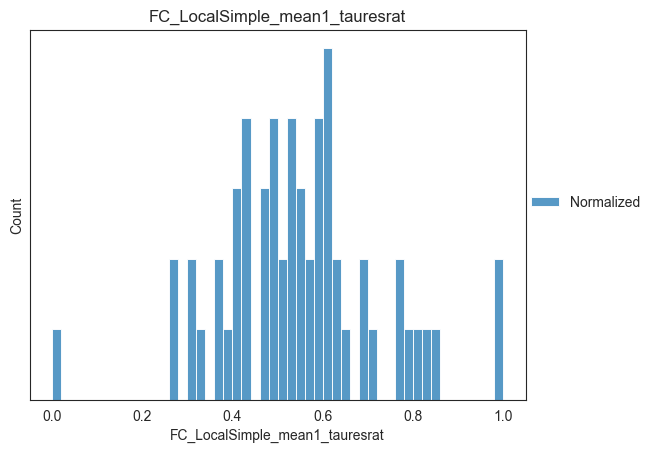

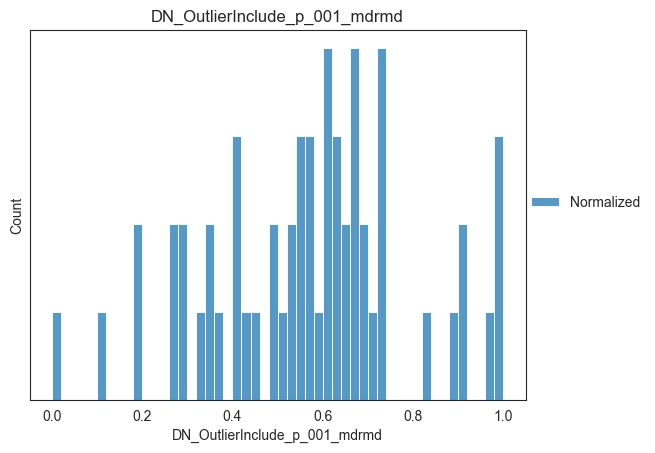

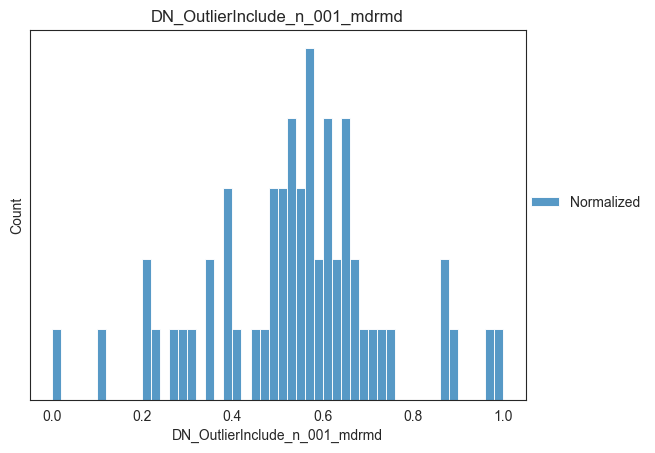

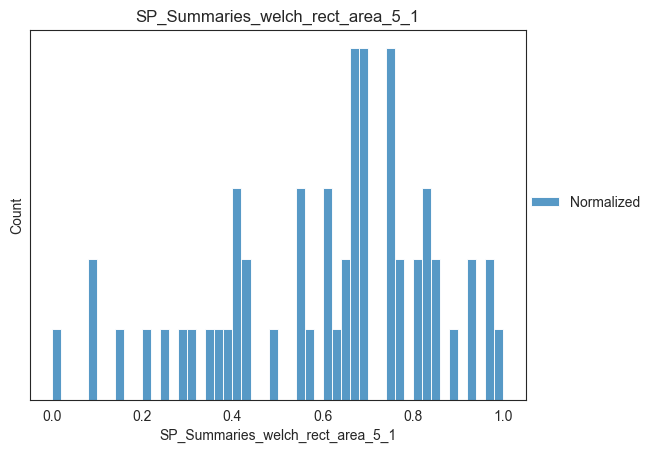

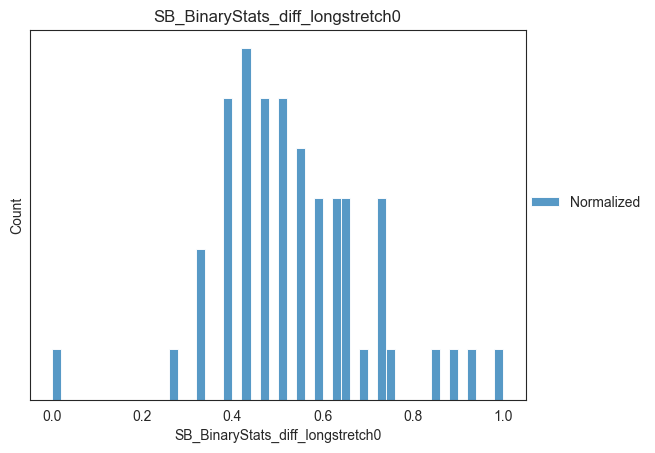

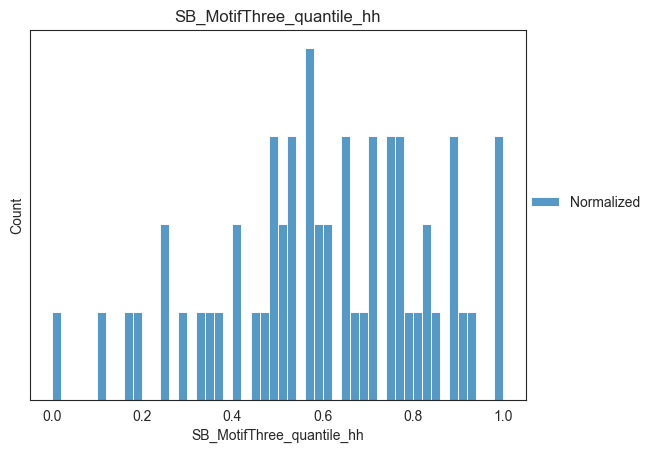

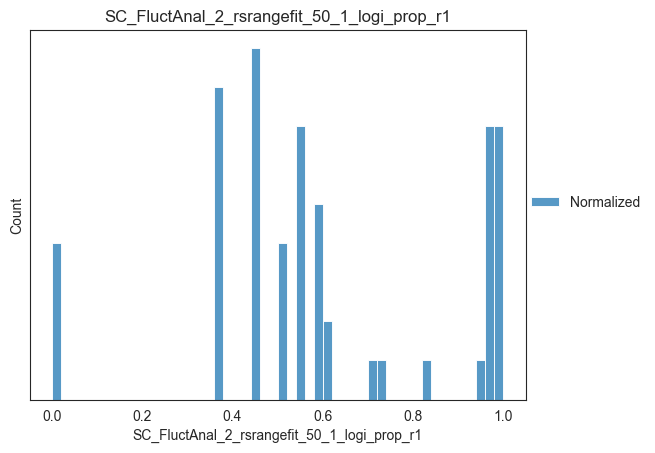

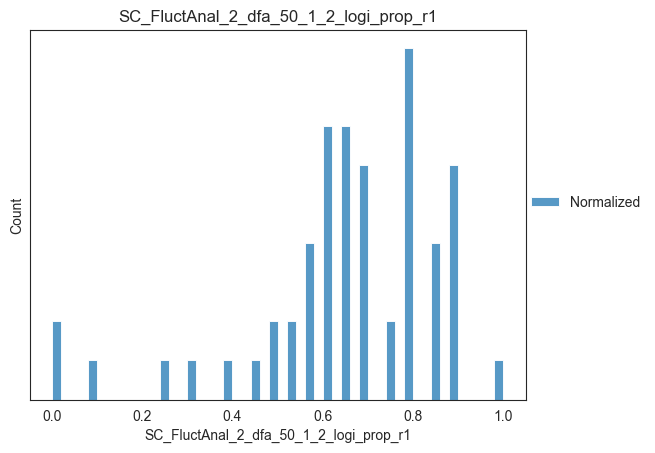

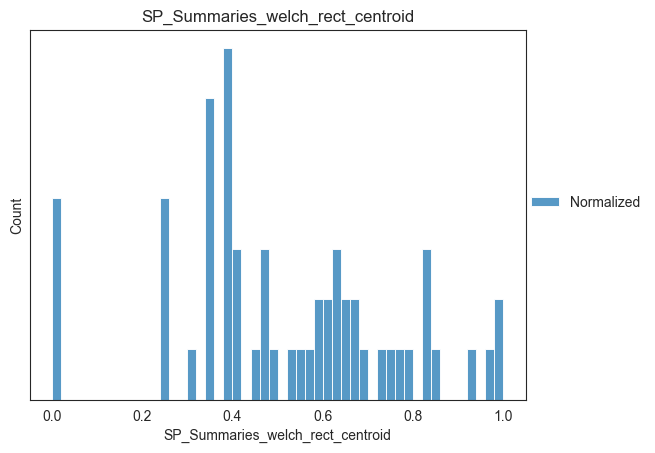

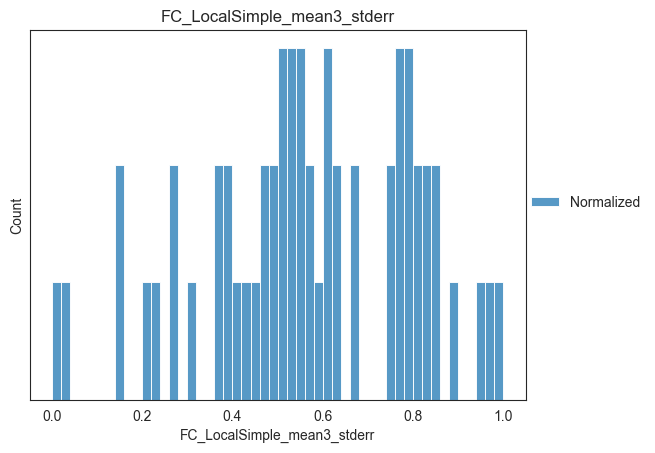

In [5]:
#Remove the least informative one    
f=values
f=f.drop(['IN_AutoMutualInfoStats_40_gaussian_fmmi'],axis=1)

#Normalization: Scale[0.0001,1]+Boxcox+Scale[0,1] and check the normalized distribution
import scipy.stats as spstats
min_max_scaler = MinMaxScaler(feature_range=(0.0001,1))
fb = min_max_scaler.fit_transform(f)
fb=pd.DataFrame(fb)

for i in range(f.shape[1]):
    feature=np.array(fb.iloc[:,i])
    l,opt_lambda=spstats.boxcox(feature)
    #print('Optimal lambda value:', opt_lambda)
    f.iloc[:,i]=spstats.boxcox(fb.iloc[:,i],lmbda=opt_lambda)

fb= MinMaxScaler(feature_range=(0,1)).fit_transform(f)
fb= pd.DataFrame(fb)
fb.columns=[x for x in values.columns if x != 'IN_AutoMutualInfoStats_40_gaussian_fmmi']

for i in range(fb.shape[1]):
    #plt.figure(dpi=600)
    #sns.kdeplot(f.iloc[:,i],label='Original')
    sns.histplot(fb.iloc[:,i],label='Normalized',bins=50)
    #sns.despine(top=True, right=True, left=False, bottom=False)
    sns.set_style('white')
    #plt.xticks([])
    plt.yticks([])
    plt.title(fb.columns[i])
    #plt.ylabel('Number')
    #plt.xlabel(fb.columns[i])
    #plt.savefig(fb.columns[i])
    plt.legend(loc=[1,0.5],frameon=False)
    plt.show()

In [6]:
new_tcs = tcs
new_fb = fb

In [7]:
good_tcs = new_tcs
good_fb = new_fb
good_tcs.index = np.arange(new_tcs.shape[0])
good_fb.index = np.arange(new_fb.shape[0])
print(good_tcs.shape)

(57, 5001)


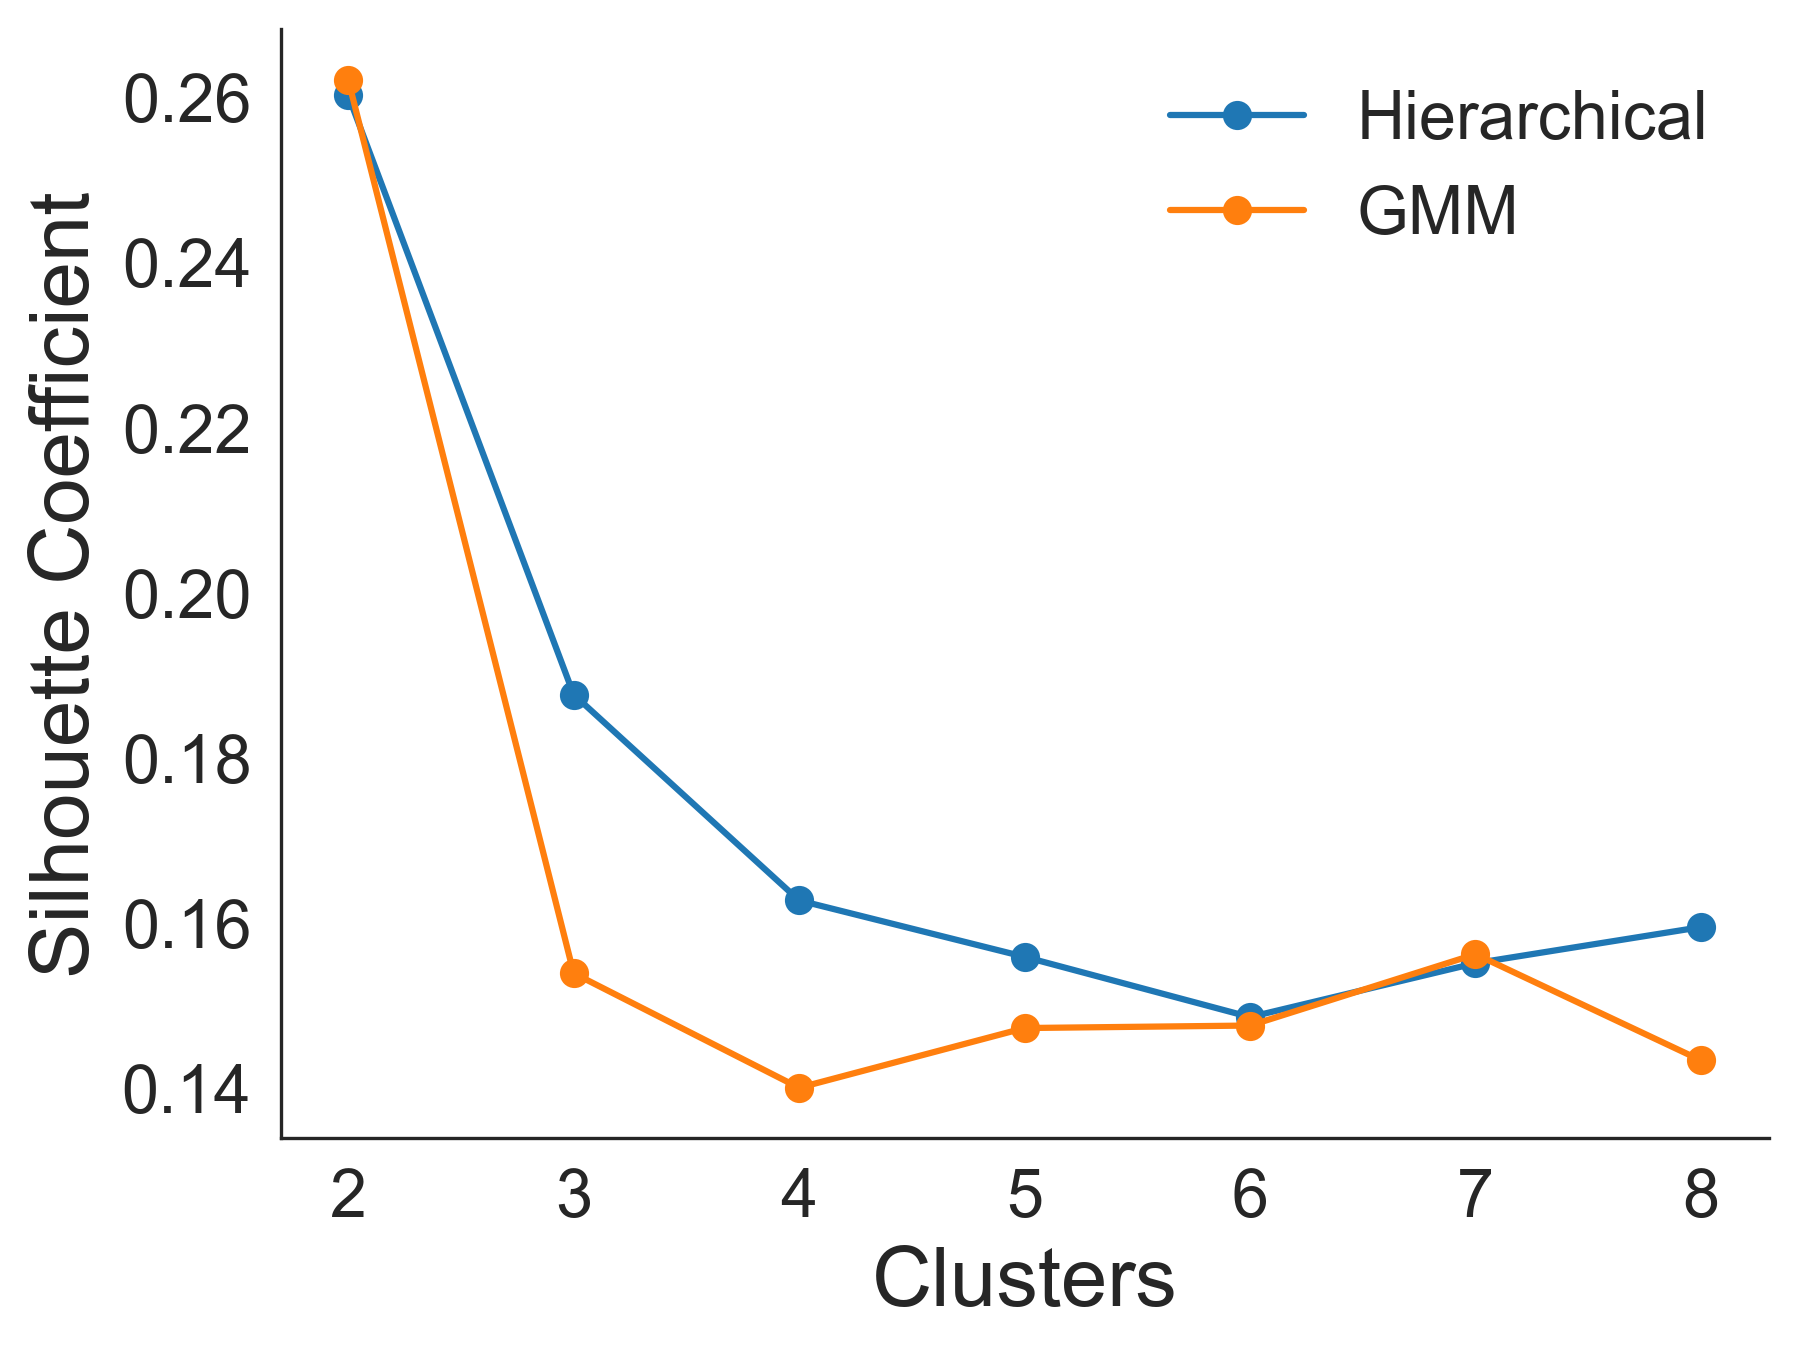

In [8]:
# Estimate k using Silhouette Coefficient - Intercluster similarity
# Comparing Hierarchical and GMM
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture as GMM
Scores = []  
g=[]
for k in range(2,9):
    estimator = AgglomerativeClustering(n_clusters=k,linkage='ward')  # 构造聚类器
    estimator.fit(good_fb)
    Scores.append(silhouette_score(good_fb,estimator.labels_,metric='euclidean'))
    estimator_g = GMM(n_components=k, random_state=0)
    estimator_g.fit(good_fb)
    g.append(silhouette_score(good_fb,estimator_g.predict(good_fb),metric='euclidean'))

X = range(2,9)
plt.figure(dpi=300,facecolor='white')
#plt.figure()
plt.xlabel('Clusters',fontsize=20)
plt.ylabel('Silhouette Coefficient',fontsize=20)
plt.plot(X,Scores,'o-',label='Hierarchical')
plt.plot(X,g,'o-',label='GMM')
#plt.title('Silhoutte')
plt.legend(fontsize=16,frameon=False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.axes().yaxis.set_tick_params(which='major', left = 'off')
#plt.axes().xaxis.set_tick_params(which='major', bottom = 'off')
#plt.savefig('silhouette coef.pdf',format='pdf',bbox_inches='tight',dpi=300)
plt.show()

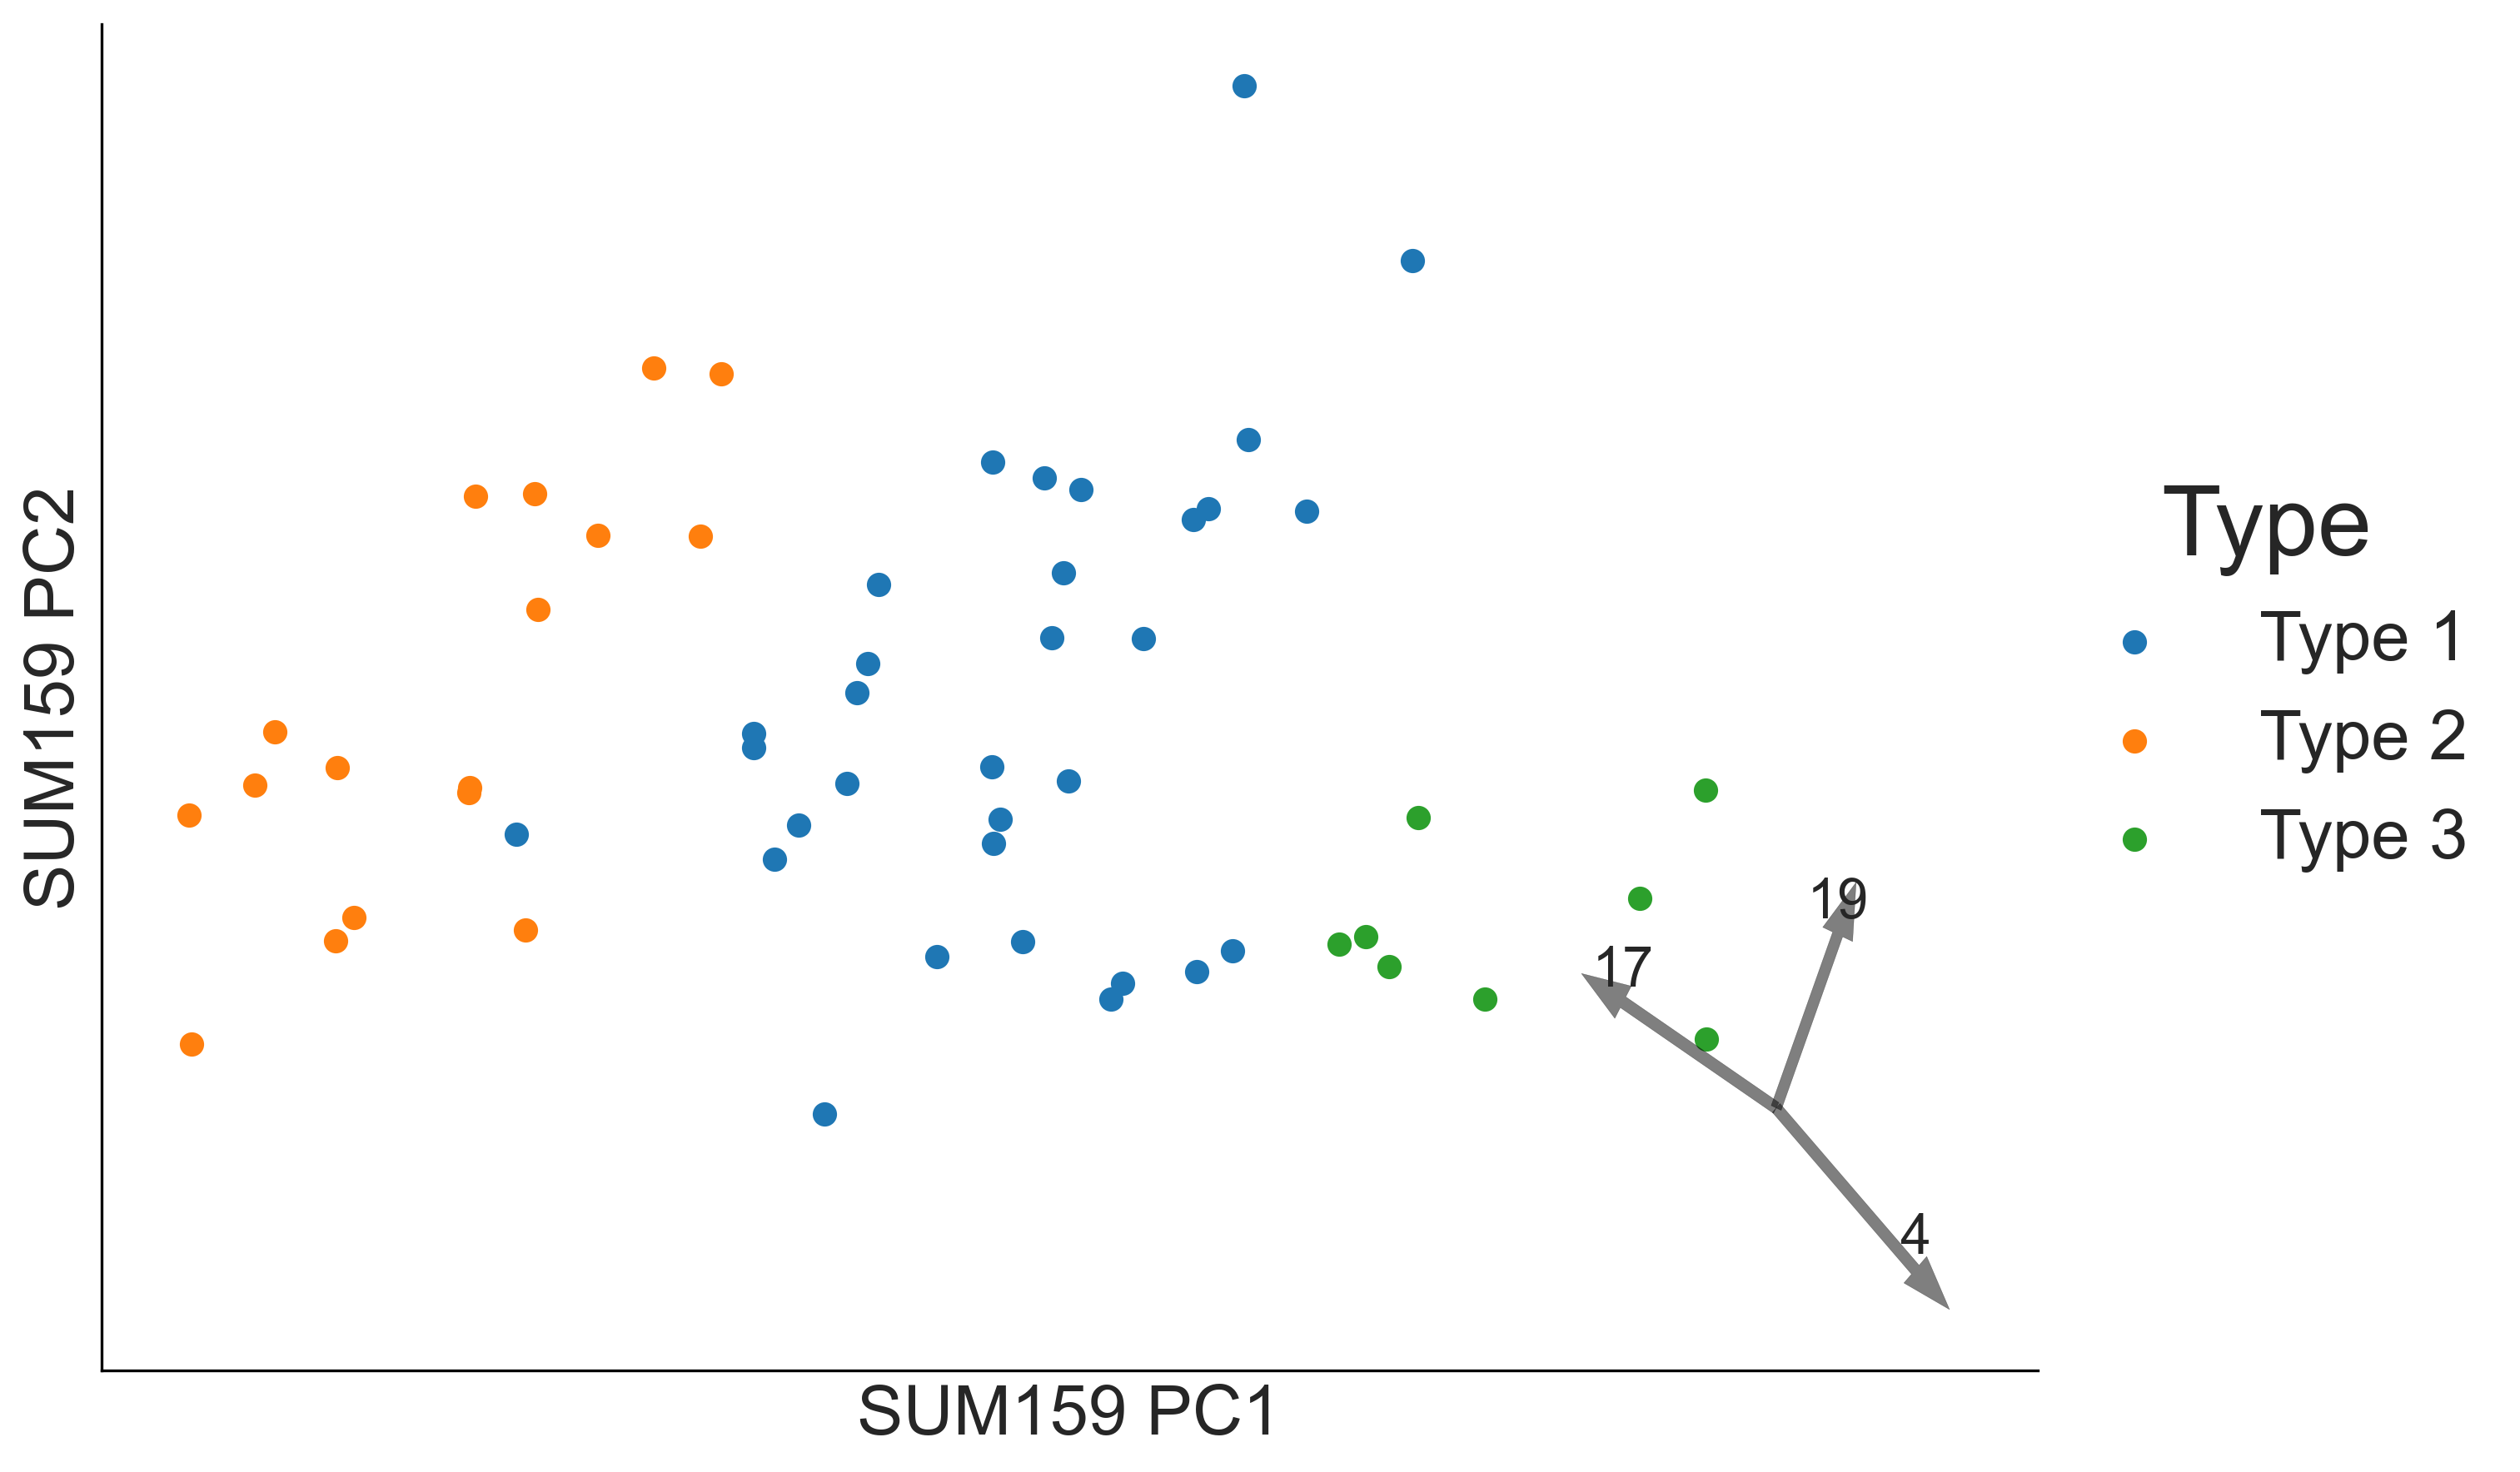

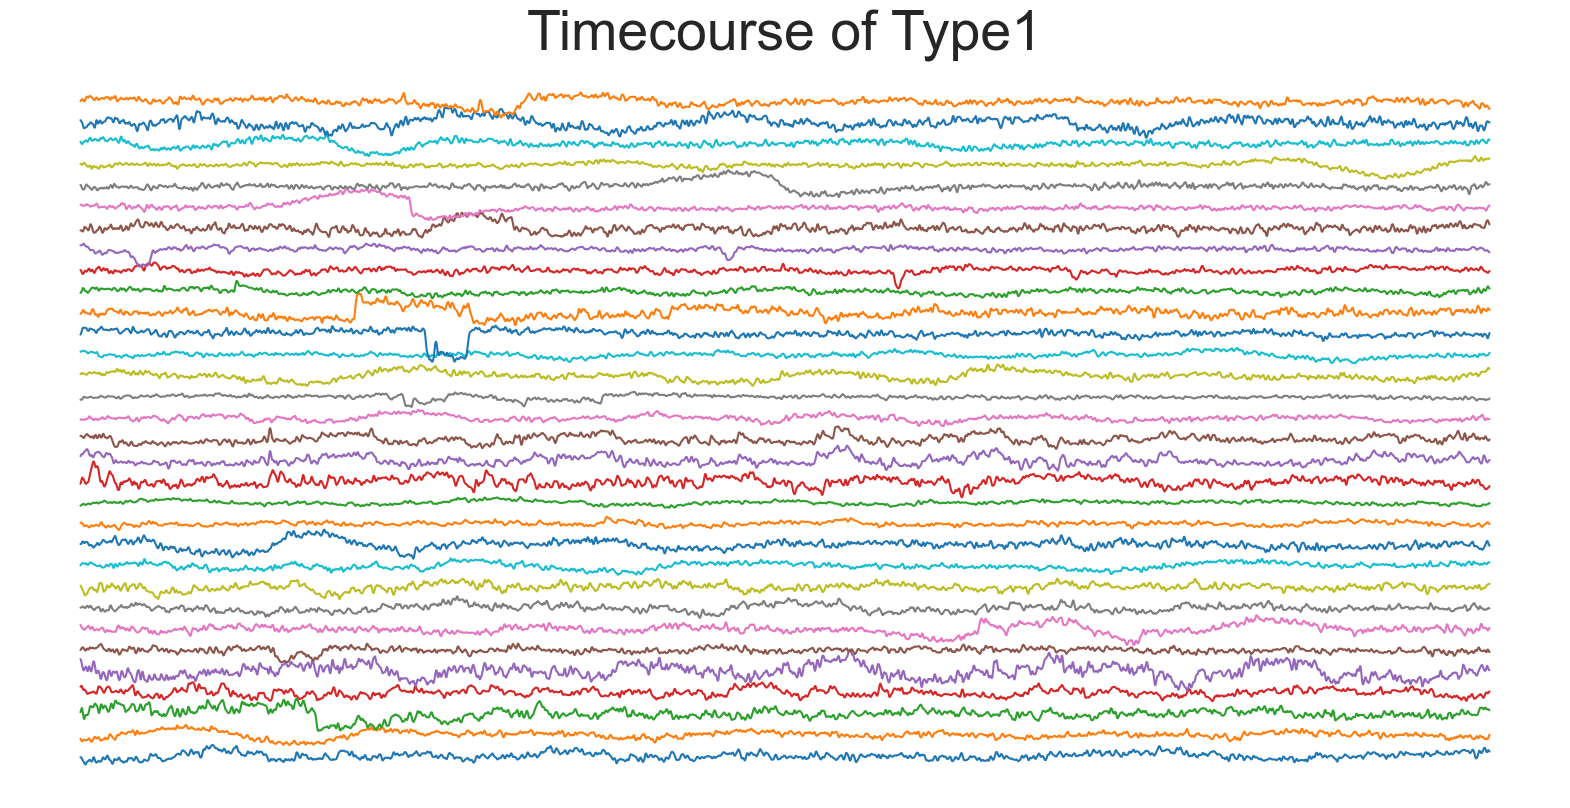

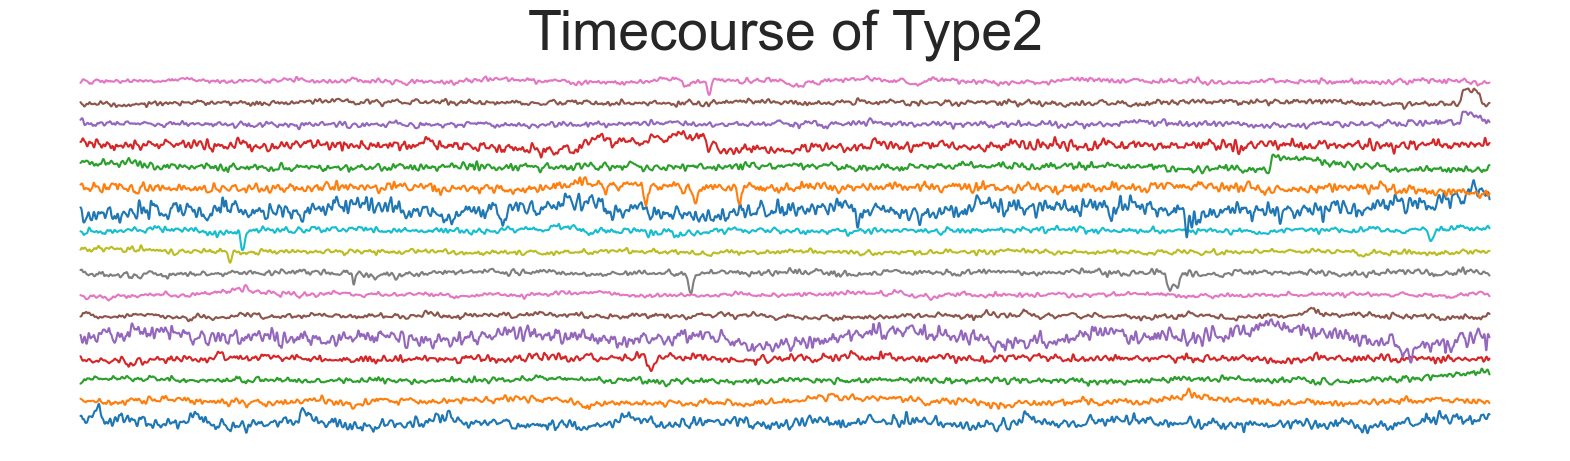

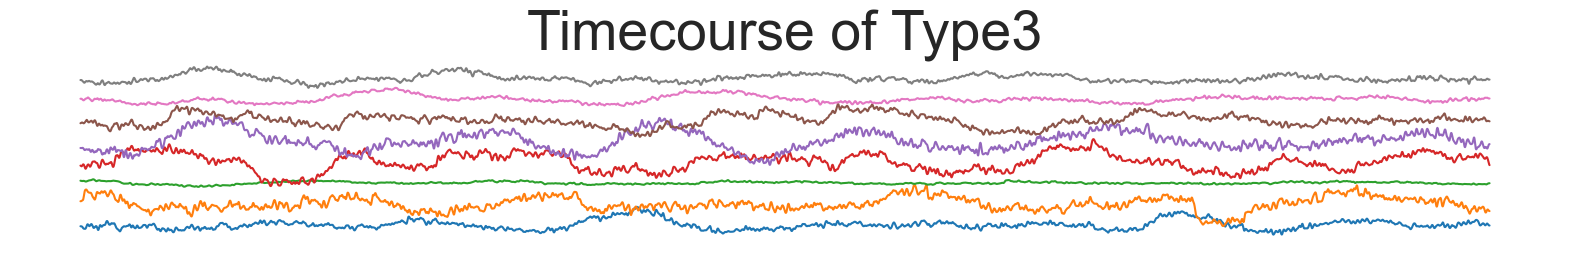

In [9]:
# Hierarchical clustering
T=0.2
from sklearn.cluster import AgglomerativeClustering

n_clusters=3
clustering = AgglomerativeClustering(linkage='ward',n_clusters=n_clusters).fit(good_fb)

ts=good_tcs.iloc[:,2:]
pca = PCA(n_components=0.8)
new_pca = pd.DataFrame(pca.fit_transform(good_fb))
importance = pca.explained_variance_ratio_
c=pca.components_

output_data = pd.concat([ pd.Series(clustering.labels_, index=good_fb.index),good_fb], axis=1)   # Output with group information
output_data.columns = ['Type']+list(good_fb.columns)  # Rename columns
output_ts = pd.concat([pd.Series(clustering.labels_, index=ts.index),ts], axis=1)   # Output with group information
output_ts.columns = ['Type'] + list(ts.columns)   # Rename columns

#output_data.to_csv('fb with label.csv')
#output_ts.to_csv('tc_filt with label.csv')

fig=plt.figure(figsize=(10,7),dpi=300)
ax=fig.add_subplot(111)
ax.set_facecolor('white')
#title=['Waving','Blinking-Large','Noisy','Blinking-Small']
#title=['Quiet','Waving','Noisy','Blinking-S','Blinking-L']
#color=['dodgerblue','darkorange','green','red','mediumpurple']
for i in range(n_clusters):
    t=new_pca[output_data['Type']==i]
    ax.scatter(t.iloc[:,0],t.iloc[:,1],
               label=f'Type {i+1}',
               marker='o',
               #color=color[i]
              )

plt.legend(fontsize=20,frameon=False,loc=[1,0.35],ncol=1,title='Type',title_fontsize=28,columnspacing=0.1)
plt.xticks([])
plt.yticks([])
#plt.title('PCA-231-Hierarchical')
kwargs={'linestyle':'-', 'lw':0.1, 'width':0.02} 
'''
for i in np.arange(c.shape[1]):
    ax.arrow(1.6,-0.6,c[0,i],c[1,i],alpha=0.5,ec='black',fc='black', **kwargs)
    ax.text(c[0,i]+1.6,c[1,i]-0.5,f'{i+1}', ha="center", va="center",fontsize=16)   
'''
for i in [3,16,18]:
    ax.arrow(1.6,-0.6,c[0,i],c[1,i],alpha=0.5,ec='black',fc='black', **kwargs)
    ax.text(c[0,i]+1.6,c[1,i]-0.55,f'{i+1}', ha="center", va="center",fontsize=16)  

ax.set_xlabel(f'{line} PC1',fontsize=20)  
ax.set_ylabel(f'{line} PC2',fontsize=20)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
#plt.savefig('PCA of 231.png',dpi=600)
#plt.savefig('PCA of 231.eps',format='eps',dpi=300)
#ax.spines['left'].set_linewidth(3)
#ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
#plt.savefig('pca of 231.pdf',format='pdf',bbox_inches = 'tight',dpi=300)
# Plot the traces in each type
for i in range(n_clusters):
    g=output_ts[output_ts['Type']==i].iloc[:,1:]
    
    fig,ax=plt.subplots(figsize=(20,g.shape[0]*0.3))
    ax.plot(np.arange(g.shape[1])*T,g.T + np.arange(g.shape[0])/70)
    ax.set_title(f'Timecourse of Type{i+1}',fontsize=40)
    ax.set_xlabel('Time(s)',fontsize=30)
    ax.set_ylabel('Fluorescence df/F',fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.axis('off')
    
    #labels = list(good_tcs[output_ts.Type==i]['cell_id_active'])
#     for j in range(g.shape[0]):
#         y=g.iloc[j,:].mean()+j/70
#         ax.text(-50,y,f'{labels[j][-2:]}',fontsize=14)

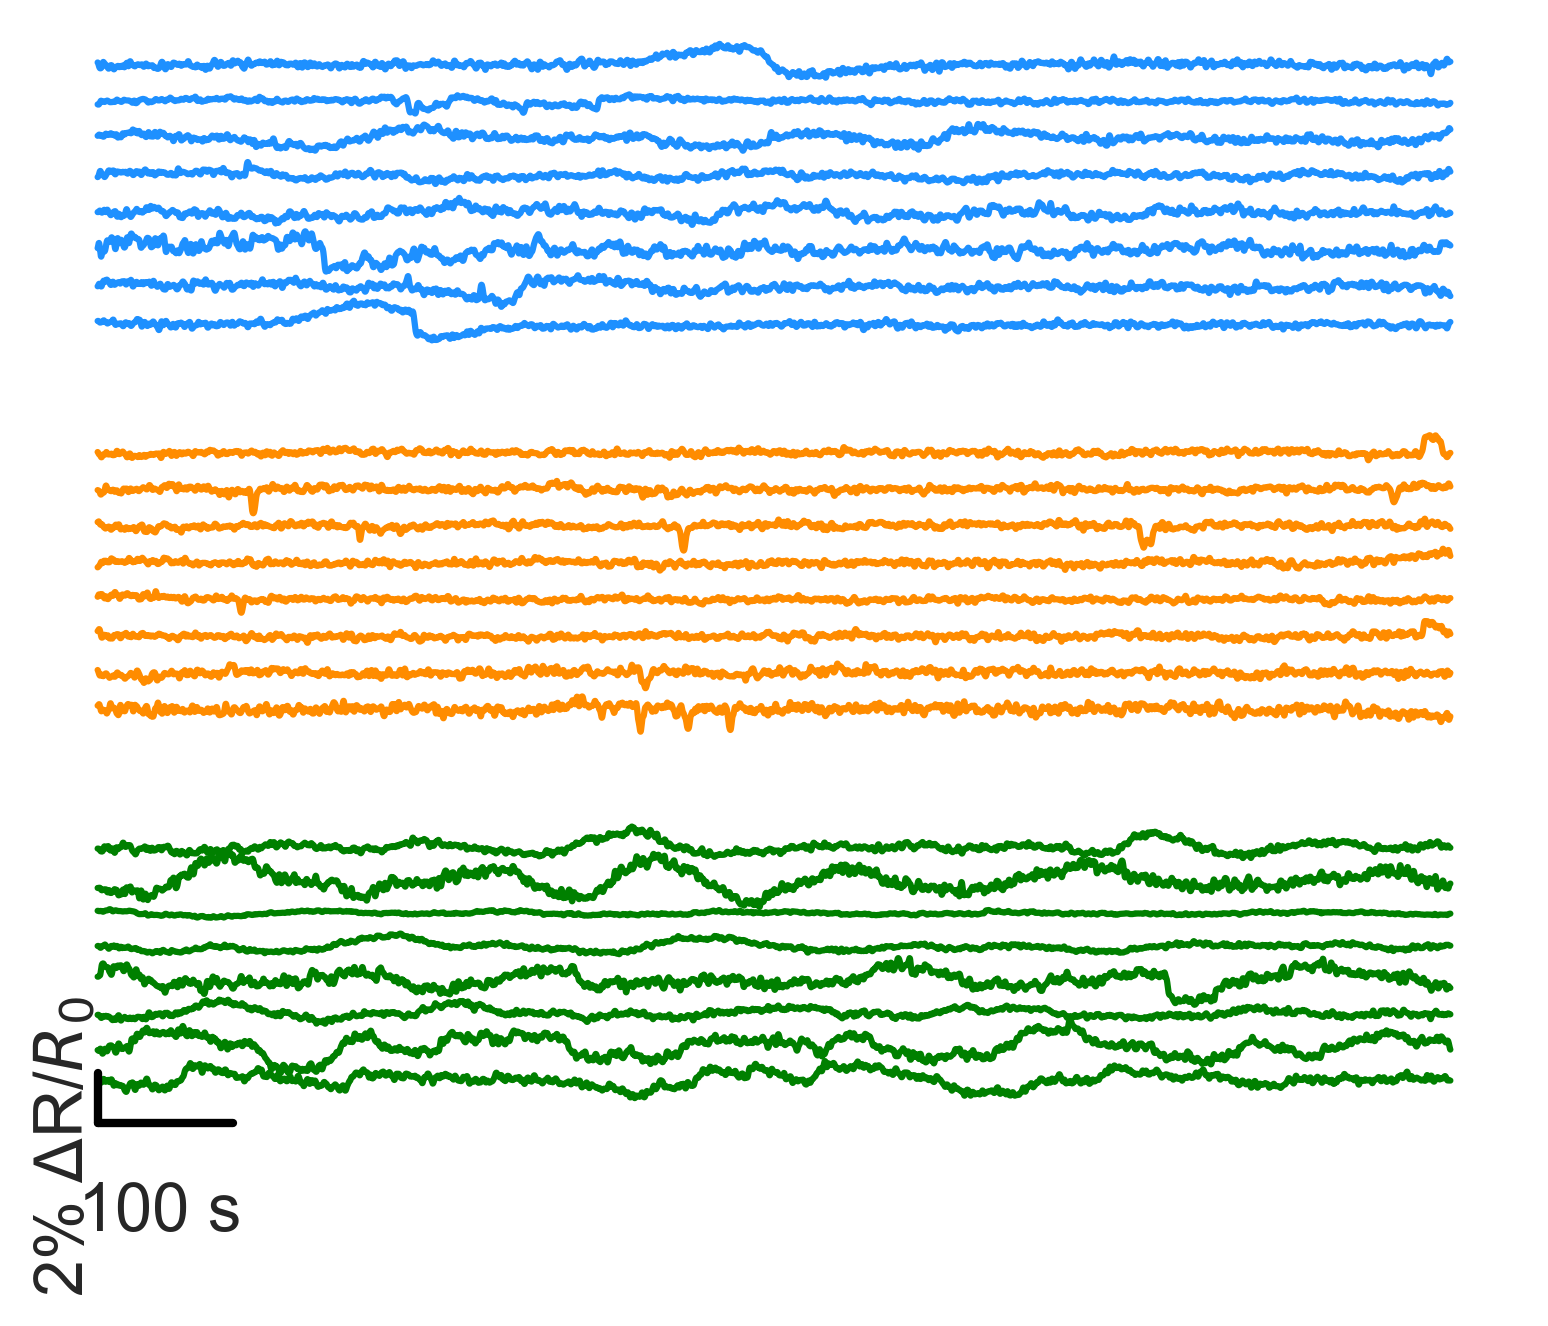

In [10]:
a=[False,False,False,False,False,False]
b=[19,17,4]
color=['dodgerblue','darkorange','green','red','mediumpurple']
plt.figure(dpi=300)
for i in range(n_clusters):
    f=output_data[output_data['Type']==i].iloc[:,1:]
    f=f.sort_values(by=fb.columns[b[i]-1],axis=0,ascending=a[i])
    t=output_ts.iloc[f.index[0:8],1:]
    T=0.2
    ts=np.array(t)
    ax = plt.subplot(n_clusters, 1, i+1)
    ax.plot(np.arange(ts.shape[1])*T,ts.T+ np.arange(ts.shape[0])/50,color=color[i])
    #ax.set_title(title[i],fontsize=20)
    #ax.set_xlabel('Time(s)')
    #ax.set_ylabel('Fluorescence df/F')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.axis('off')
ax.plot([0,0],[ts[:8].min() - 0.01,ts[:8].min() - 0.01 + 0.03],linewidth = 2, color = 'black')
ax.plot([0,100],[ts[:8].min() - 0.01,ts[:8].min() - 0.01],linewidth = 2, color='black')
ax.text(46,0.92,'100 s',fontsize=16,horizontalalignment='center',verticalalignment='center')
ax.text(-25,0.96,'2% \u0394R/$R_0$',rotation=90,fontsize=16,horizontalalignment='center',verticalalignment='center')  
#plt.tight_layout()
plt.show()
    #plt.savefig('Reps-'+title[i]+'.pdf',format='pdf',bbox_inches='tight',dpi=300)

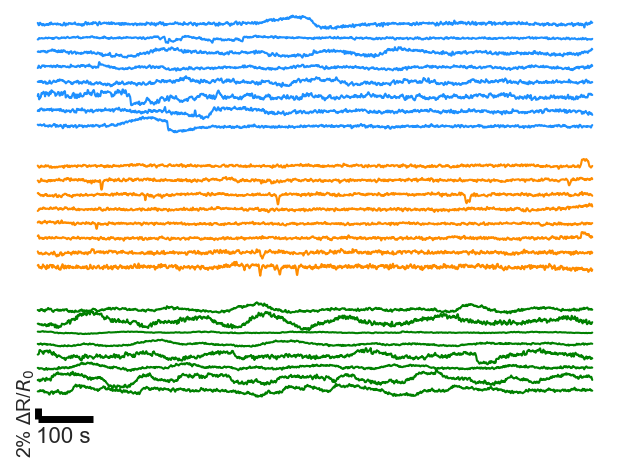

In [11]:
a=[False,False,False,False,False,False]
b=[19,17,4]
color=['dodgerblue','darkorange','green','red','mediumpurple']
plt.figure()
for i in range(n_clusters):
    
    # Set up the plot
    ax = plt.subplot(n_clusters, 1, i+1)
    
    f=output_data[output_data['Type']==i].iloc[:,1:]
    f=f.sort_values(by=fb.columns[b[i]-1],axis=0,ascending=a[i])
    t=output_ts.iloc[f.index[0:8],1:]
    T=0.2
    ts=np.array(t)
    ax.plot(np.arange(ts.shape[1])*T,ts.T+ np.arange(ts.shape[0])/50,color=color[i])
    plt.axis('off')
    #plt.legend(loc=[1,0.4],frameon=False)
plt.hlines(y=0.95, xmin=0, xmax=100, linewidth=5, color='black')
plt.vlines(x=0, ymin=0.95, ymax=0.97, linewidth=5, color='black')
plt.text(46,0.92,'100 s',fontsize=16,horizontalalignment='center',verticalalignment='center')
plt.text(-20,0.96,'2% \u0394R/$R_0$',rotation=90,fontsize=14,horizontalalignment='center',verticalalignment='center')
plt.tight_layout()
plt.show()

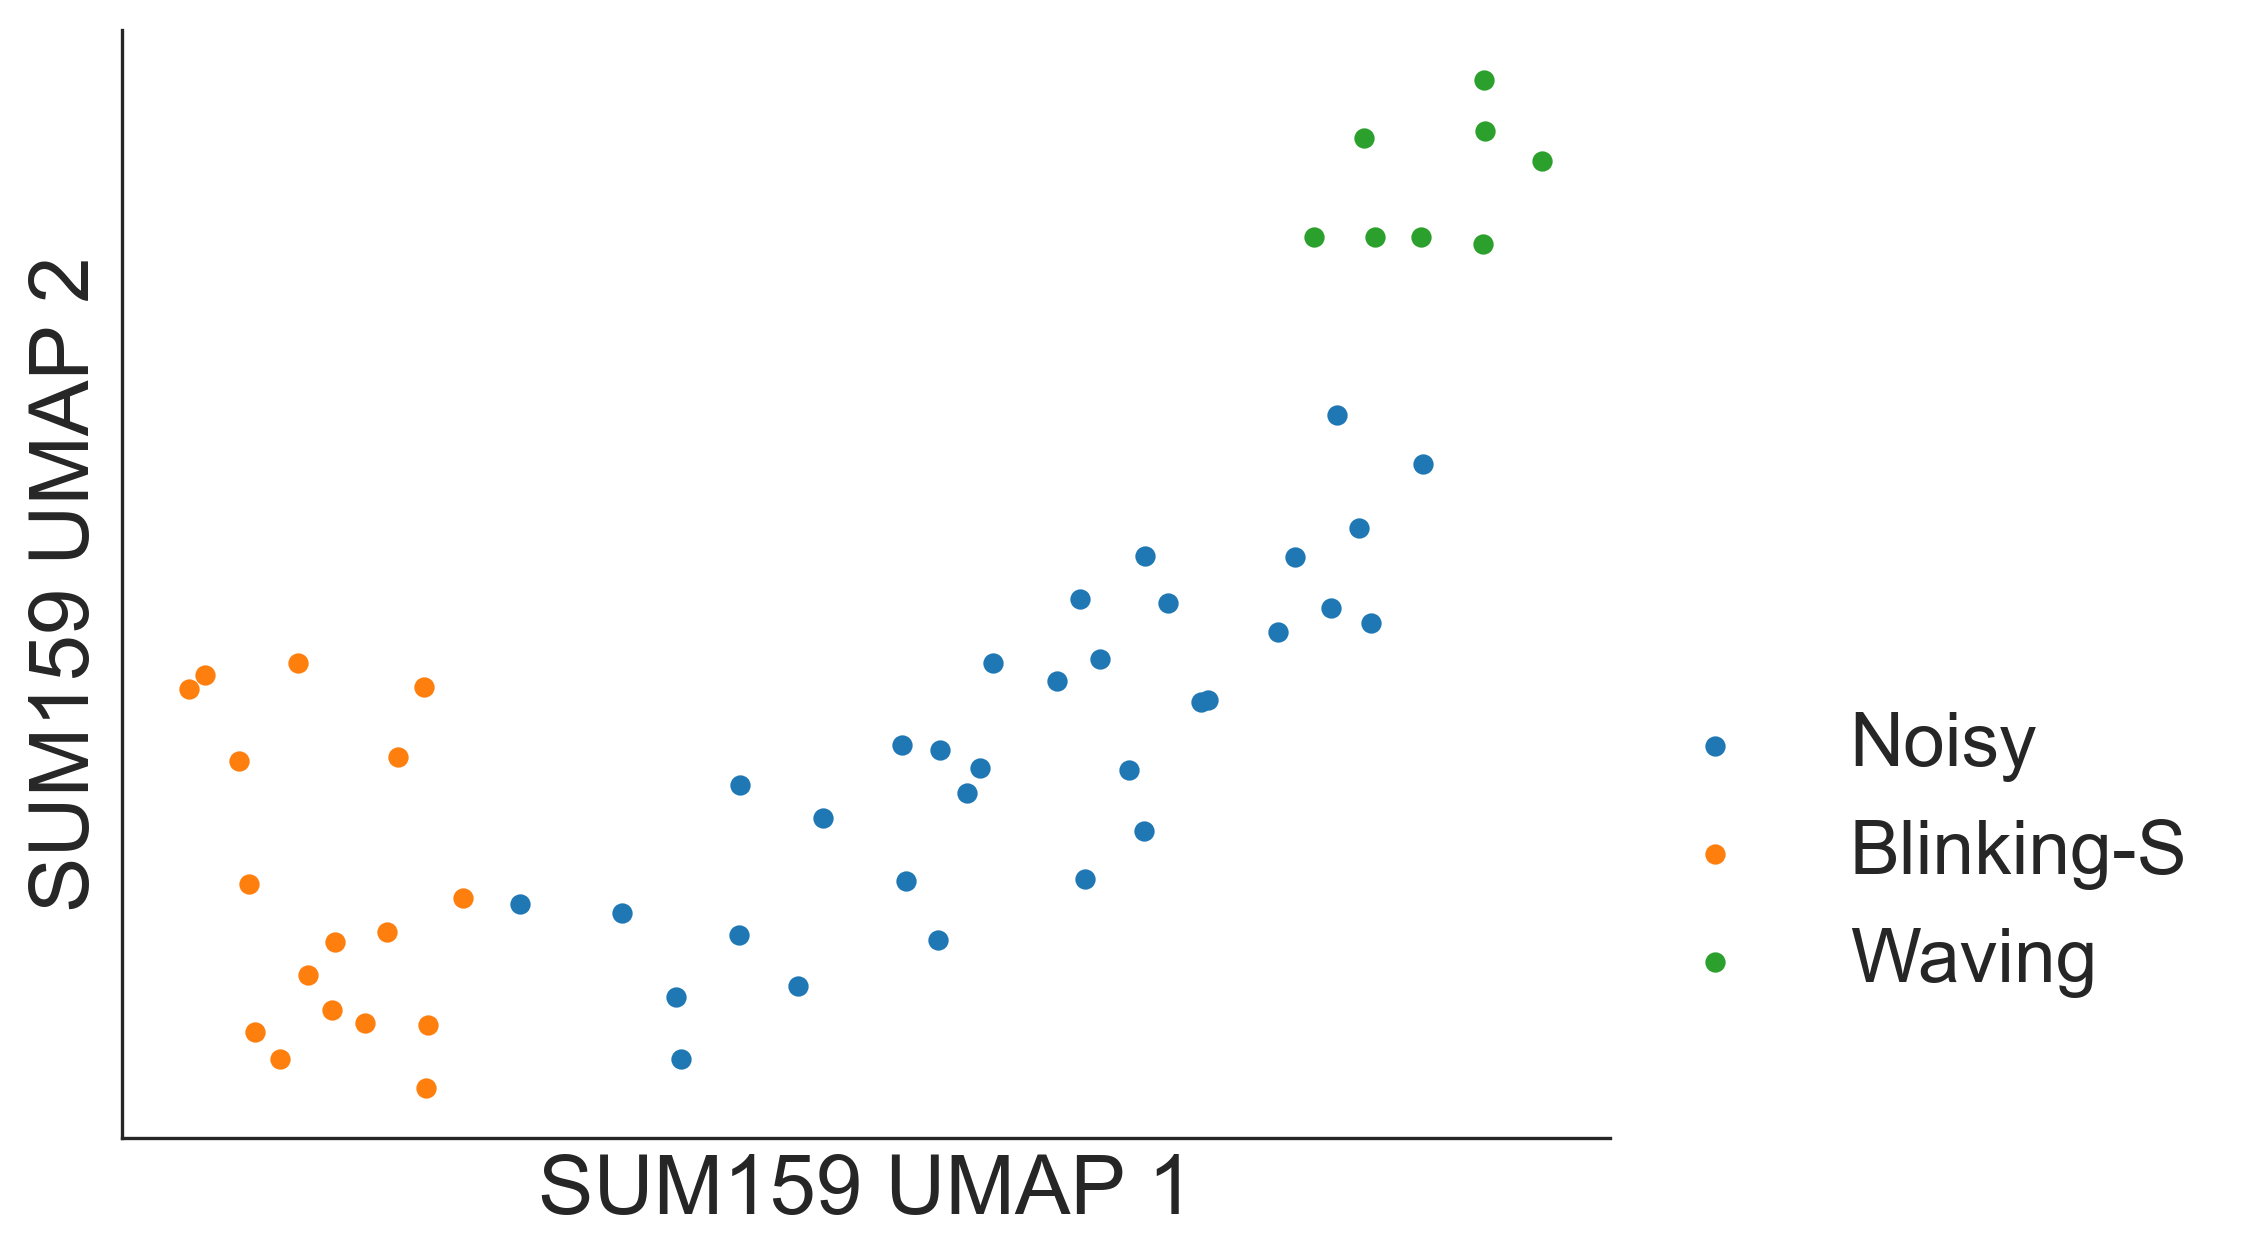

In [18]:
import umap
save_dir = Path(r'C:\Users\Firefly\Desktop\breast_lines_figure_Yilin')
labels = ['Noisy','Blinking-S','Waving']
reducer = umap.UMAP(n_components=3)
new_umap = pd.DataFrame(reducer.fit_transform(good_fb))
fig=plt.figure(dpi=300)
ax=fig.add_subplot(111)
#color=['lightcoral','indianred','brown','maroon']

for i in range(n_clusters):
    t = new_umap[output_ts['Type']==i]
    ax.scatter(t.iloc[:,0],t.iloc[:,1], label = f'{labels[i]}', marker = 'o',s = 15)
#ax.set_xlim([-1.5,1.5])
#ax.set_ylim([-0.75,1.25])
plt.xlabel(rf'{line} UMAP 1',fontsize=20)  
plt.ylabel(rf'{line} UMAP 2',fontsize=20)
plt.legend(fontsize=18,frameon=False,loc=[1,0.1])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig(Path(save_dir,'sum159_umap.eps'),format='eps',dpi=300)
new_umap.to_csv('sum159_umap.csv')
#plt.savefig('combine tsne space.eps',format='eps',dpi=600)
#plt.savefig('combine tsne space.png',dpi=600)

C:\Users\Firefly\anaconda3\envs\cancer_tutorial\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\Firefly\anaconda3\envs\cancer_tutorial\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


([], [])

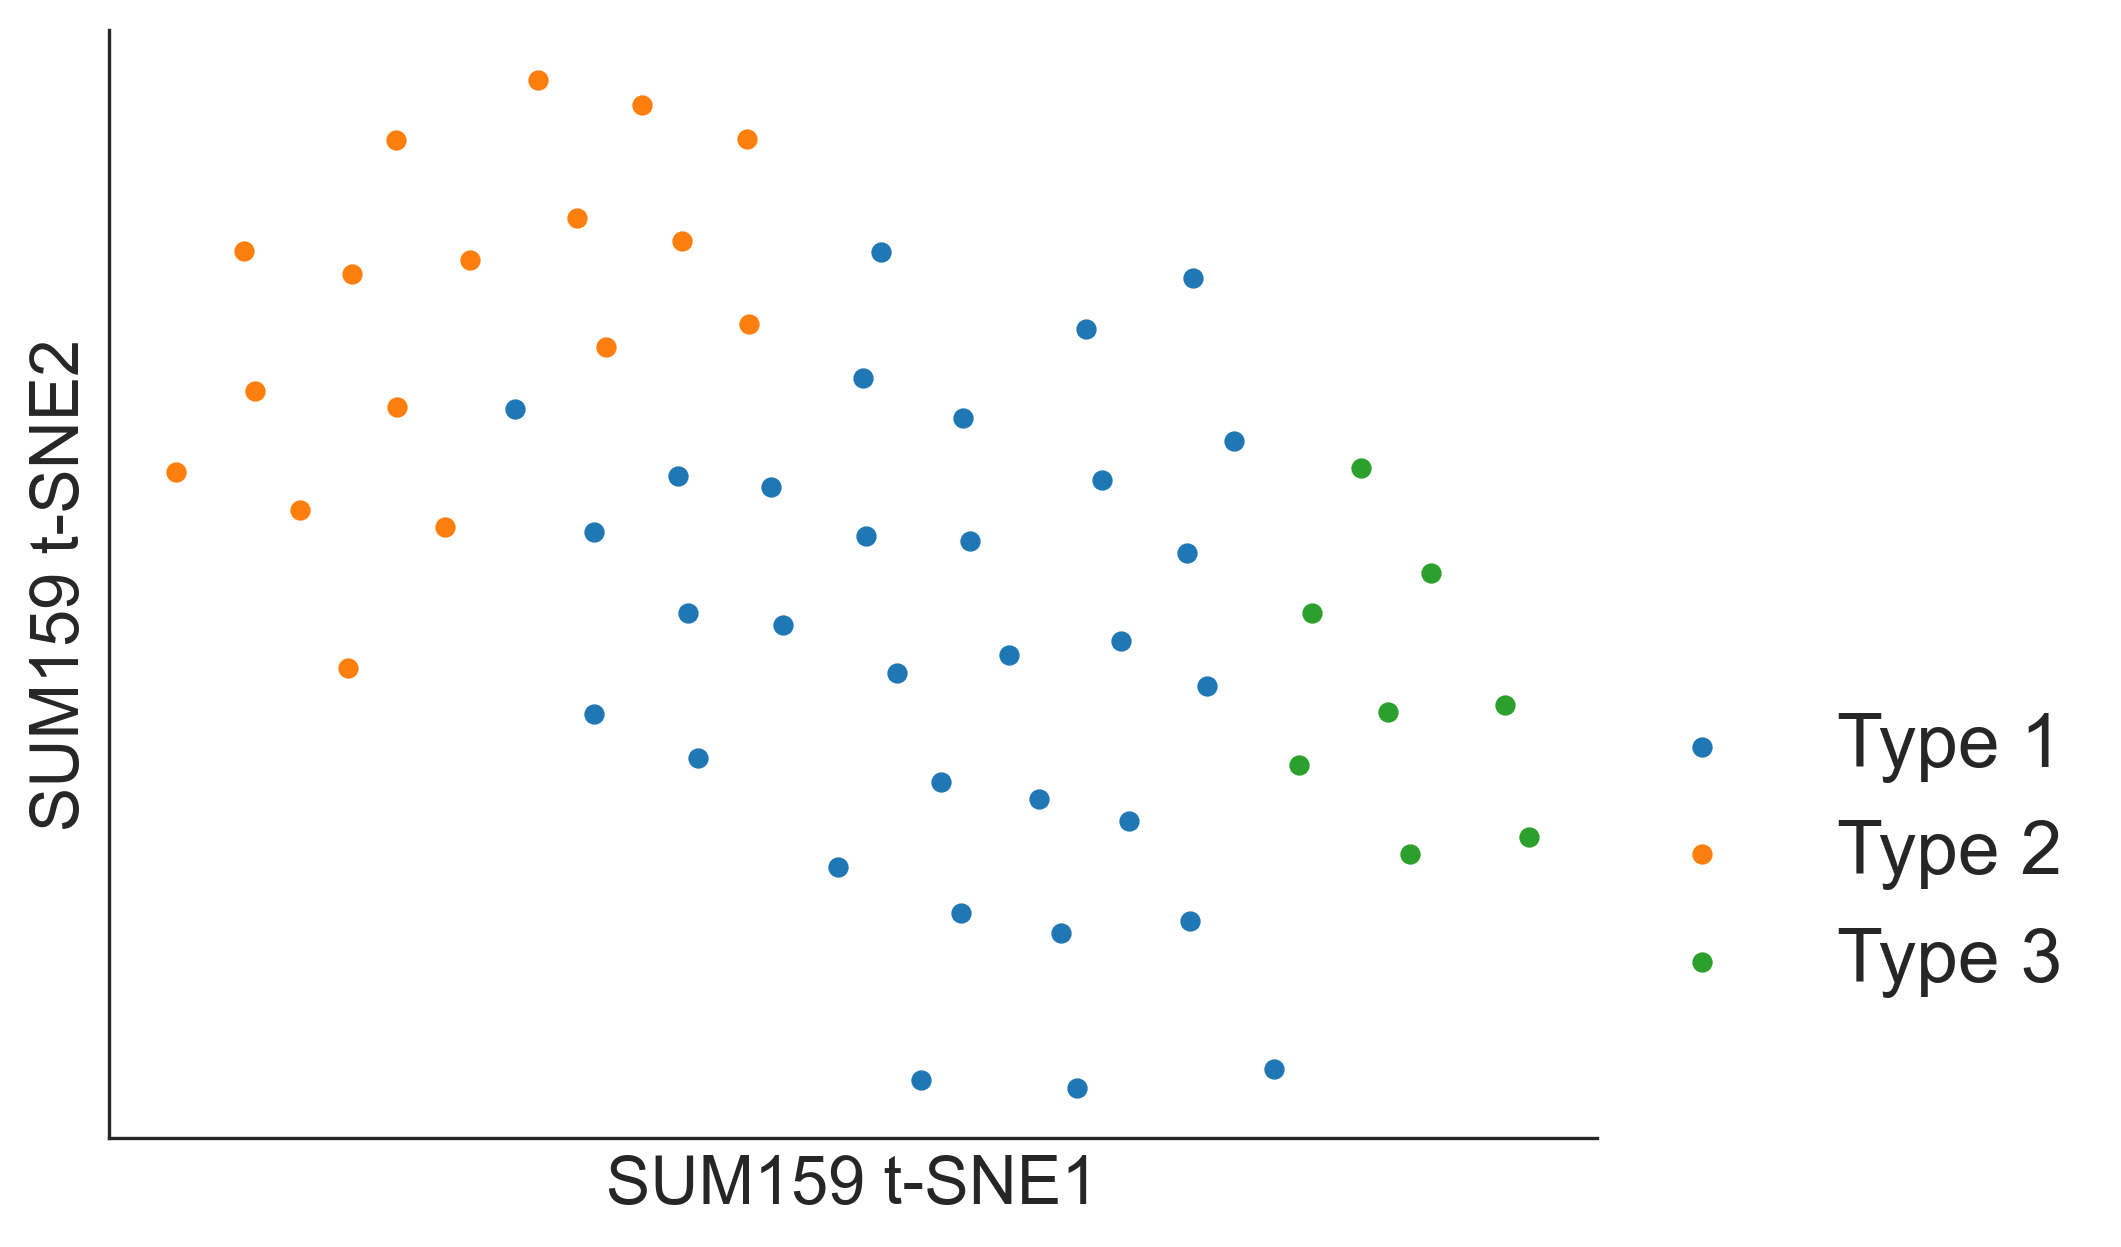

In [16]:
from sklearn.manifold import TSNE

tsne=TSNE()
new_tsne = pd.DataFrame(tsne.fit_transform(good_fb))
fig=plt.figure(dpi=300)
ax=fig.add_subplot(111)
#color=['lightcoral','indianred','brown','maroon']

for i in range(n_clusters):
    t = new_tsne[output_ts['Type']==i]
    ax.scatter(t.iloc[:,0],t.iloc[:,1], label = f'Type {i+1}', marker = 'o',s = 15)
#ax.set_xlim([-1.5,1.5])
#ax.set_ylim([-0.75,1.25])
plt.xlabel(rf'{line} t-SNE1',fontsize=16)  
plt.ylabel(rf'{line} t-SNE2',fontsize=16)
plt.legend(fontsize=18,frameon=False,loc=[1,0.1])
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xticks([])
plt.yticks([])
#plt.savefig('combine tsne space.eps',format='eps',dpi=600)
#plt.savefig('combine tsne space.png',dpi=600)